# Result Visualization
This notebook creates all the plots you can see in the thesis. Since all plots are made for Latex the title will be printed and the fonts might be bigger.

In [47]:
# load the model and training functions
import classformer as cf

# load the libaries
from aeon.datasets import load_classification
import json 
import os
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
from critdd import Diagram
import scipy.spatial.distance as sd
from itertools import zip_longest
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# setting font sizeto 30

# define Colors from ETH corporate design
ETH_Blau = '#215CAF'
ETH_Petrol = '#007894'
ETH_Bronze =  '#8E6713'
ETH_Rot = '#B7352D'
ETH_Purpur = '#A7117A'
ETH_Grau = '#6F6F6F'

In [48]:
path= "/scratch/sbuehrer/ClassFormer"
test="04"
os.chdir(path)	
os.listdir(os.getcwd()+"/checkpoints/"+test)

['Epilepsy', 'BasicMotions', 'ArticularyWordRecognition']

In [49]:
dataset_name="BasicMotions"
X_train, y_train, meta_data = load_classification(dataset_name,split="train",return_metadata=True)
X_test, y_test = load_classification(dataset_name,split="test",return_metadata=False)
if(not meta_data["equallength"]):
    maxlen=max(max([max(map(len, observation)) for observation in X_train]),max([max(map(len, observation)) for observation in X_test]))
    X_train=cf.pad_dataset(X_train,maxlen)
    X_test=cf.pad_dataset(X_test,maxlen)
integer_mapping = {x: i for i,x in enumerate(meta_data["class_values"])}
inverse_integer_mapping = {i: x for i,x in enumerate(meta_data["class_values"])}
sparse_label_train = [integer_mapping[word] for word in y_train]
sparse_label_test = [integer_mapping[word] for word in y_test]

## Wavelet Transform

Observation 12 at dimension 0 in 'BasicMotions' dataset labeled as running. Time series on top and resulting scalogram from wavlet transform at the bottom.


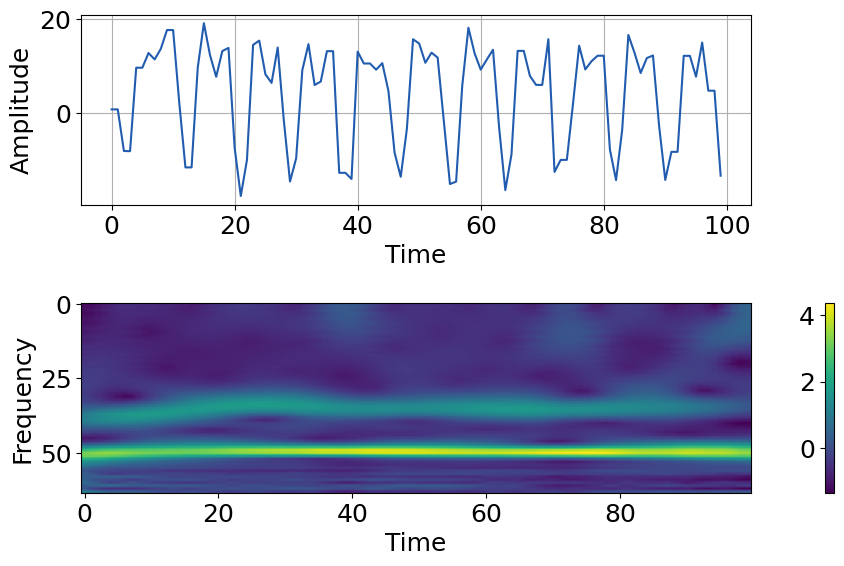

In [74]:
import matplotlib.gridspec as gridspec
plt.rc('font', size=18) #controls default text size

def plot_wavlet_transform(X, y,index):
        fig = plt.figure(tight_layout=True,figsize=(10,6))
        gs = gridspec.GridSpec(2, 2, width_ratios=(5, 1), height_ratios=(4, 4))

        ax = fig.add_subplot(gs[0, 0])
        ax.plot(X[index],color=ETH_Blau)
        ax.grid()
        ax.set_ylabel("Amplitude")
        ax.set_xlabel("Time")

        ax1 = fig.add_subplot(gs[1, 0])
        wavlet_transform = cf.WaveletTransform(freq_size=64)
        X=wavlet_transform.call(X)
        pos=ax1.imshow(np.flip(np.transpose(X[index]),0), aspect="auto")
        ax1.set_ylabel("Frequency")
        ax1.set_xlabel("Time")

        cax = fig.add_subplot(gs[1, 1])
        cbar=fig.colorbar(pos, ax=cax,orientation="vertical",location="left")
        plt.tight_layout()
        cax.remove()
        print("Observation {} at dimension {} in '{}' dataset labeled as {}. Time series on top and resulting scalogram from wavlet transform at the bottom.".format(index[0],index[1],dataset_name,y[index[0]]))
        plt.savefig('src/figures/wavelet_transform.pdf')
        plt.show()
plot_wavlet_transform(X_test,y_test,(12,0))




## Load results

In [5]:
vers=os.listdir(os.getcwd()+"/checkpoints/"+test+"/"+dataset_name)[-1]
with open(path+"/checkpoints/{}/{}/{}/raw_data.json".format(test,dataset_name,vers), "r") as read_file:
        config = json.load(read_file)

### print history

Metrics of model trained on "Epilepsy"


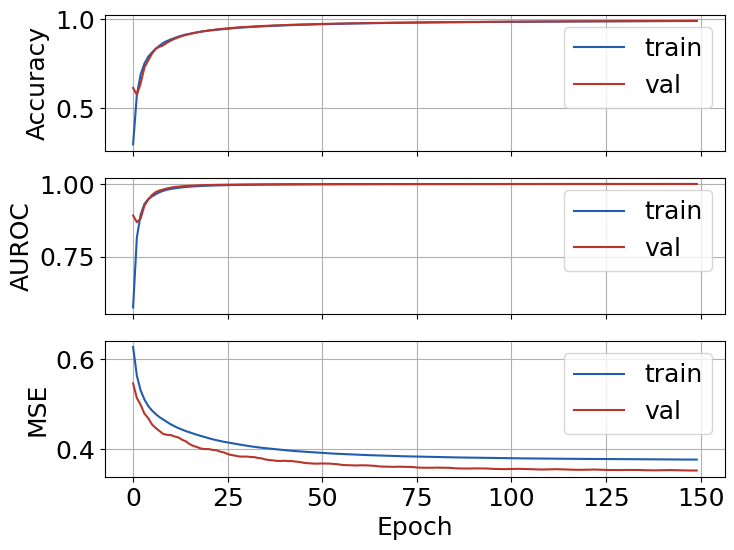

In [6]:
metrics=["Accuracy","AUROC","MSE"]
history={}
history["train"] = np.transpose(np.array(config["train"]))
history["val"] = np.transpose(np.array(config["val"]))
plt.rc('font', size=18)
def plot_history(history,metrics):
    fig, axes = plt.subplots(len(metrics), sharex=True, figsize=(8, 6))
    print('Metrics of model trained on "{}"'.format(dataset_name))
    for ind,key in enumerate(metrics):
        axes[ind].set_ylabel(key)
        axes[ind].plot(history["train"][ind],color=ETH_Blau,label="train")
        axes[ind].plot(history["val"][ind],color=ETH_Rot,label="val")
        axes[ind].grid()
        axes[ind].legend()
        if ind==len(metrics)-1:
            axes[ind].set_xlabel("Epoch")
    plt.savefig('src/figures/metrics.pdf')
    plt.show()
plot_history(history,metrics)

### build model

In [7]:
model=cf.Classformer(
            output_size=len(meta_data["class_values"]),
            recon_size=list(eval(config["cwtm_shape"])),
            d_model=config["d_model"],
            num_heads=config["num_heads"],
            dropout_rate=config["dropout_rate"],
            dff=config["dff"],
            recon_dff=config["recon_dff"],
            num_tsa=config["num_tsa"],
            size_T=config["size_T"],
            size_F=config["size_F"],
            mask_ratio=config["mask_ratio"],
            top_ratio=config["top_ratio"])

num=150
best_epoch=[i for i  in sorted(os.listdir(path+"/checkpoints/{}/{}/{}".format(test,dataset_name,vers))) if str(num) in i][1][:-6]
print(best_epoch)
model.load_weights(path+"/checkpoints/{}/{}/{}/{}".format(test,dataset_name,vers,best_epoch))

150.mask.ckpt


## classification with t-sne

In [8]:
print(os.getcwd())

/scratch/sbuehrer/ClassFormer


2D scatter plot of the t-SNE result of the time series on the ``Epilepsy'' test dataset.
{'epilepsy': 0, 'walking': 1, 'running': 2, 'sawing': 3}


[t-SNE] Computing 137 nearest neighbors...
[t-SNE] Indexed 138 samples in 0.001s...
[t-SNE] Computed neighbors for 138 samples in 0.136s...
[t-SNE] Computed conditional probabilities for sample 138 / 138
[t-SNE] Mean sigma: 11.779797
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.177216
[t-SNE] KL divergence after 300 iterations: 0.315229
(138,)


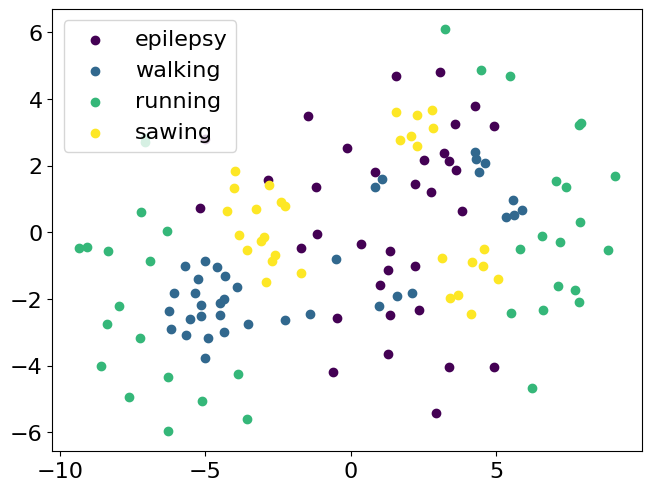

In [9]:
def mapper(x,integer_mapping):
    return(integer_mapping[x])

def plot_t_sne(X,y,perplexity,inverse_integer_mapping,name):
    print(integer_mapping)
    flatten=tf.keras.layers.Flatten()
    x=flatten(X)
    feat_cols = [ 'step'+str(i) for i in range(x.shape[1]) ]
    df = pd.DataFrame(x,columns=feat_cols)
    df['y'] = y
    result=df[feat_cols].values
    if(x.shape[1]>100):
        pca = PCA(n_components=min(len(y),100,x.shape[1]))
        result = pca.fit_transform(result)

    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=300)
    tsne_results = tsne.fit_transform(result)
    df['tsne_01'] = tsne_results[:,0]
    df['tsne_02'] = tsne_results[:,1]
    print(df['tsne_02'].shape)
    fig, ax = plt.subplots(layout="constrained")
    colors = cm.viridis(np.linspace(0, 1, len(inverse_integer_mapping)))
    for i,c in zip(inverse_integer_mapping.keys(),colors):
        temp=df.loc[df['y'] ==i]
        ax.scatter(temp['tsne_01'],temp['tsne_02'] , color=c,label=inverse_integer_mapping[i])

    ax.legend()
    plt.savefig('src/figures/{}.pdf'.format(name))
    plt.show()

plt.rc('font', size=16) #controls default text size
print("2D scatter plot of the t-SNE result of the time series on the ``{}'' test dataset.".format(dataset_name))
plot_t_sne(X_test,sparse_label_test,50,inverse_integer_mapping,"t_sne_raw")


## T-SNE after wavelet transform

{'epilepsy': 0, 'walking': 1, 'running': 2, 'sawing': 3}
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 138 samples in 0.016s...
[t-SNE] Computed neighbors for 138 samples in 0.084s...
[t-SNE] Computed conditional probabilities for sample 138 / 138
[t-SNE] Mean sigma: 61.684023
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.251541
[t-SNE] KL divergence after 300 iterations: 0.184965
(138,)


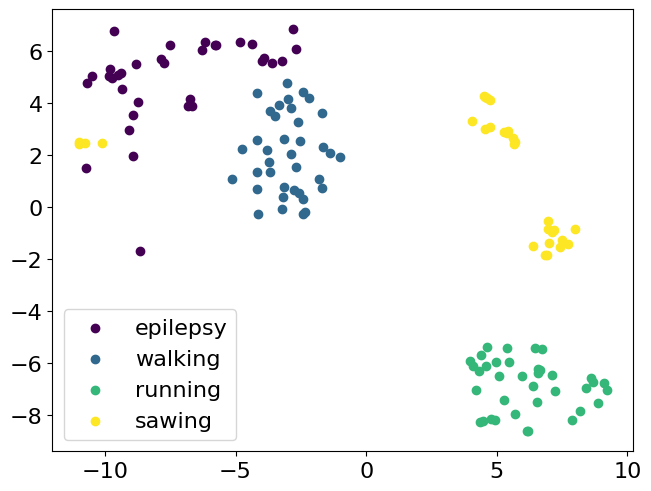

In [10]:
wavlet_transform = cf.WaveletTransform(freq_size=config["freq_domain_size"])
X_train_freq=wavlet_transform.call(X_train)
X_test_freq=wavlet_transform.call(X_test)
plot_t_sne(X_test_freq,sparse_label_test,30,inverse_integer_mapping,"t_sne_wavelet")


## T-SNE after DPW

{'epilepsy': 0, 'walking': 1, 'running': 2, 'sawing': 3}
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 138 samples in 0.004s...
[t-SNE] Computed neighbors for 138 samples in 0.100s...
[t-SNE] Computed conditional probabilities for sample 138 / 138
[t-SNE] Mean sigma: 15.728978
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.017120
[t-SNE] KL divergence after 300 iterations: 0.339926
(138,)


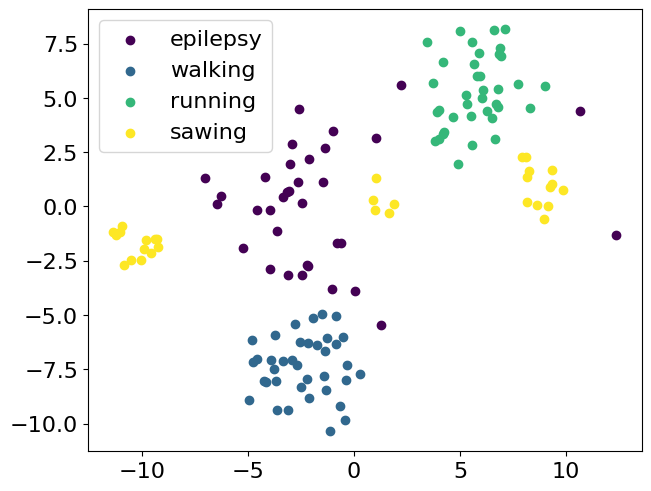

{'epilepsy': 0, 'walking': 1, 'running': 2, 'sawing': 3}
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 138 samples in 0.011s...
[t-SNE] Computed neighbors for 138 samples in 0.085s...
[t-SNE] Computed conditional probabilities for sample 138 / 138
[t-SNE] Mean sigma: 47.428073
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.863972
[t-SNE] KL divergence after 300 iterations: 0.233767
(138,)


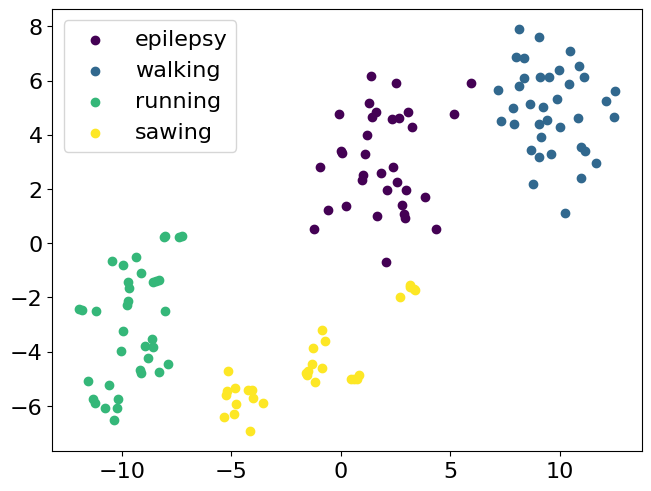

{'epilepsy': 0, 'walking': 1, 'running': 2, 'sawing': 3}
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 138 samples in 0.001s...
[t-SNE] Computed neighbors for 138 samples in 0.108s...
[t-SNE] Computed conditional probabilities for sample 138 / 138
[t-SNE] Mean sigma: 23.587380
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.066380
[t-SNE] KL divergence after 300 iterations: 0.182176
(138,)


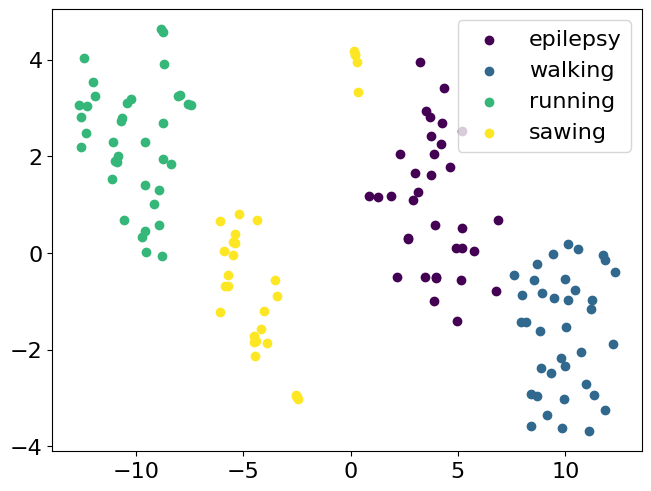

{'epilepsy': 0, 'walking': 1, 'running': 2, 'sawing': 3}
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 138 samples in 0.000s...
[t-SNE] Computed neighbors for 138 samples in 0.079s...
[t-SNE] Computed conditional probabilities for sample 138 / 138
[t-SNE] Mean sigma: 53.180329
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.721436
[t-SNE] KL divergence after 300 iterations: 0.193441
(138,)


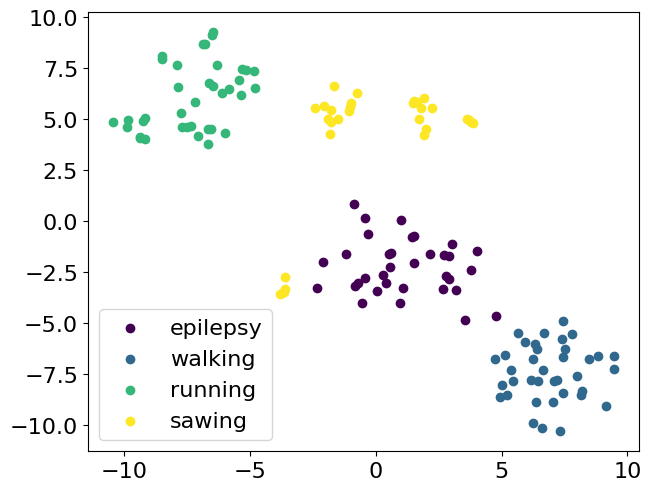

In [11]:
output = model(X_test_freq,reconstructing=False, training=False)
val=model.get_intermediate_val()
for ind,i in enumerate(val):
    if ind==len(val)-1:
        g=[]
        flatten=tf.keras.layers.Flatten()
        for s in i:
            g.append(flatten(s))
        i=tf.concat(g,axis=1)
    plot_t_sne(i,sparse_label_test,30,inverse_integer_mapping,"tsa")


## Weight Analysis

In [12]:
from mpl_toolkits.mplot3d import Axes3D

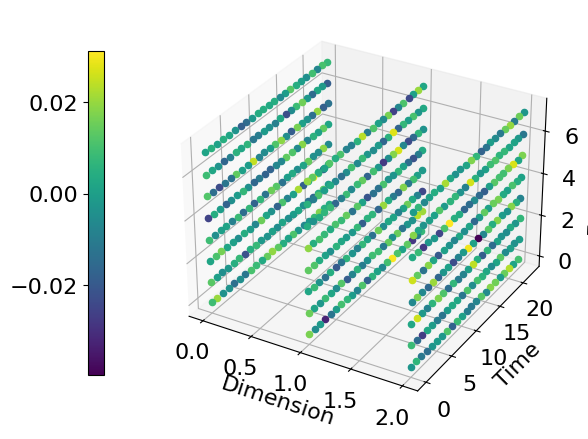

In [13]:
dpw_weights=[i for i in model.trainable_variables if 'dimension_patch_wise_embedding' in i.name]
plt.rcParams["axes.labelpad"]
def plot_pos_weight(pos_weights):
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111, projection="3d")
    pos_weights=np.mean(dpw_weights[1],axis=-1)
    mini, maxi = (np.min(pos_weights),np.max(pos_weights))
    cm = plt.get_cmap('viridis')
    norm=mpl.colors.Normalize(mini, maxi)
    for x in range(pos_weights.shape[0]):
        for y in range(pos_weights.shape[1]):
            for z in range(pos_weights.shape[2]):
                ax.scatter(x,y,z, color=cm(norm(pos_weights[x,y,z])))
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'),  ax=ax,location='left',shrink=0.6)
    ax.set_xlabel("Dimension")
    ax.set_ylabel("Time", rotation=45)
    ax.set_zlabel("Frequency", rotation=90)
    plt.savefig("src/figures/position_weights.pdf")
    plt.show()

plot_pos_weight(pos_weights=dpw_weights[1])

<Figure size 640x480 with 0 Axes>

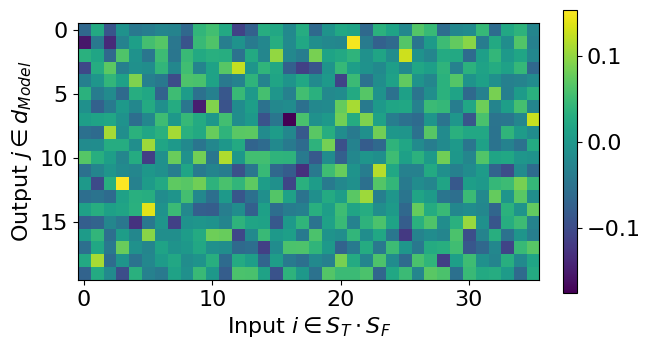

In [14]:
def plot_lin(weights):
    plt.tight_layout()
    fig, ax = plt.subplots(layout="constrained")
    im=plt.imshow(weights)
    fig.colorbar(im,ax=ax, location='right',shrink=0.6) 
    ax.set_xlabel("Input $i\in S_T \cdot S_F$")
    ax.set_ylabel("Output $j \in d_{Model}$")
    plt.savefig("src/figures/lin_weight.pdf")
plot_lin(weights=dpw_weights[0])

## Attention Scores

(100, 3, 8, 4, 24, 24)


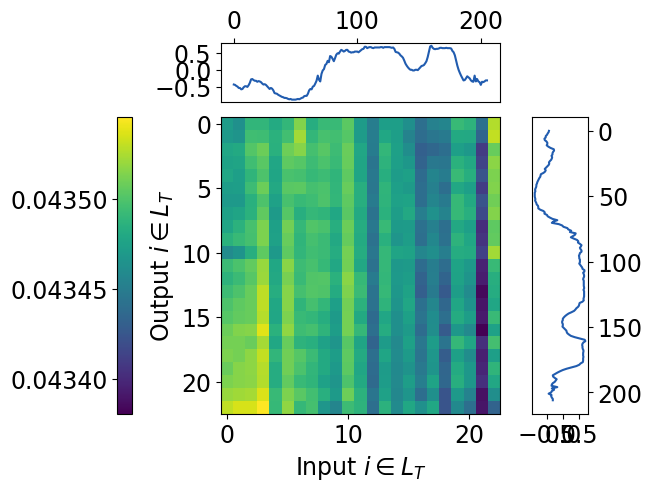

In [15]:

def print_attention_fancy(data,name,x,index=(1,0)):
    plt.rc('font', size=17) #controls default text size
    mask=-1
    matrix=data[0][1][index[0]][index[1]][0]
    print(data[0][1].shape)

    matrix=np.mean(matrix,axis=0)[:mask,:mask]


    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(2,2,  width_ratios=(5, 1), height_ratios=(1, 5),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
    ax = fig.add_subplot(gs[1, 0])
    ax_x = fig.add_subplot(gs[0, 0])
   
    ax_x.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax_y = fig.add_subplot(gs[1, 1])
    ax_y.invert_yaxis()
    ax_y.tick_params(right=True, labelright=True, left=False, labelleft=False)

    im = ax.imshow(matrix, aspect='auto')
    fig.colorbar(im,ax=ax, location='left') 
    ax.set_xlabel("Input $i\in L_T$")
    ax.set_ylabel("Output $i\in L_T$")

    ax_x.plot(x[index],color=ETH_Blau)
    le=len(x[index])
    ax_y.plot(x[index],np.linspace(0,le,le),color=ETH_Blau)
    plt.savefig("src/figures/{}.pdf".format(name,index[1]))
    plt.show()
    return

def plot_scalogram(X):
        plt.tight_layout()
        im=plt.imshow(np.flip(np.transpose(X),0), aspect="auto")

y_pred = model(X_test_freq[:100],reconstructing=False, training=False)
print_attention_fancy(model.get_attention_score(),"sumed_attention",X_test,(3,0))

    # y_pred = model(X_test_freq[:100],reconstructing=True, training=False)
    # print_attention_fancy(model.get_attention_score(),"no_mask",X_test,(2,i))



## DTW 

(100, 3, 8, 4, 24, 24)


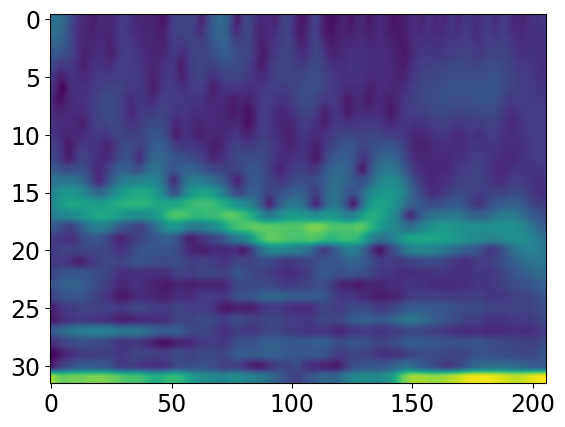

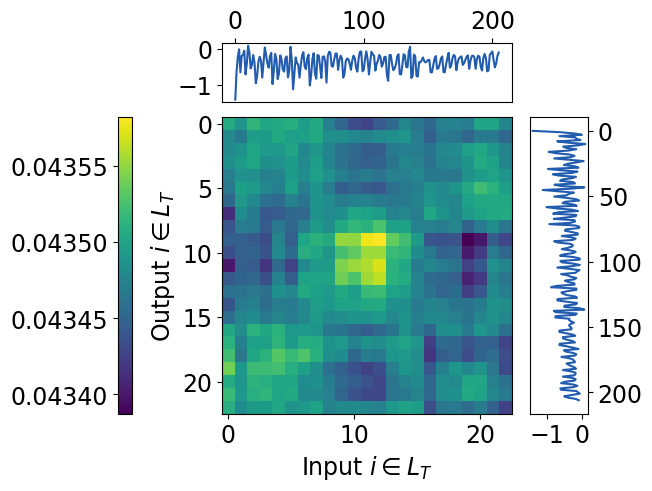

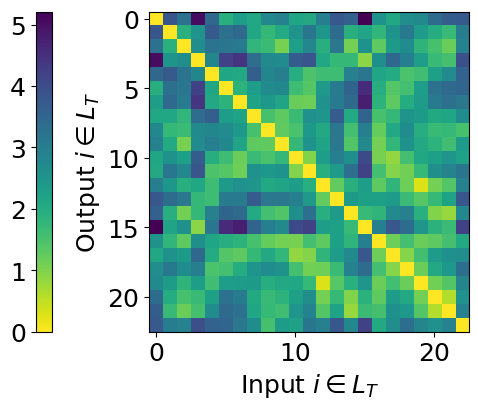

(100, 3, 8, 4, 24, 24)


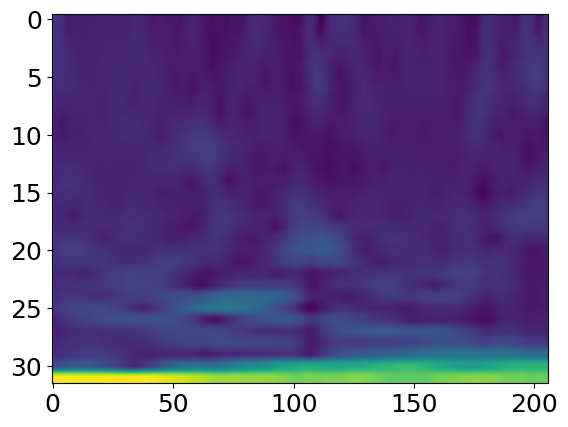

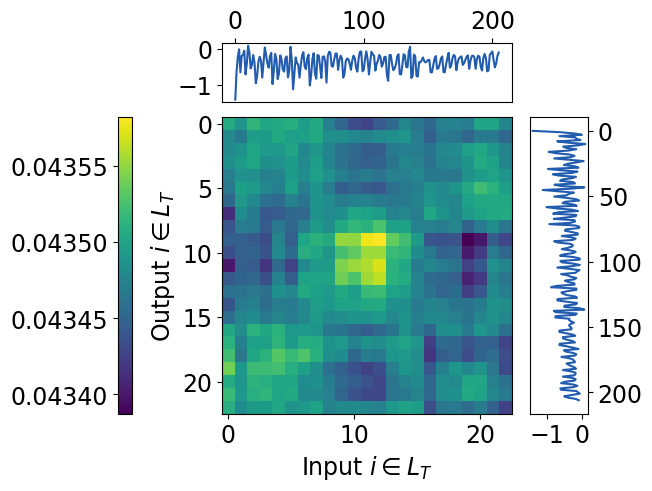

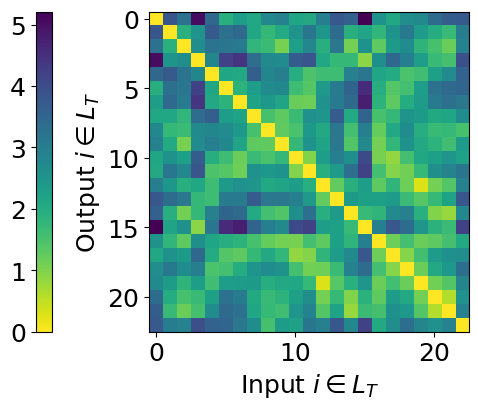

(100, 3, 8, 4, 24, 24)


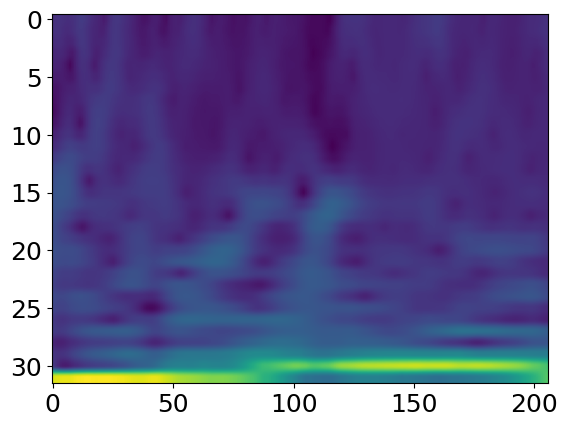

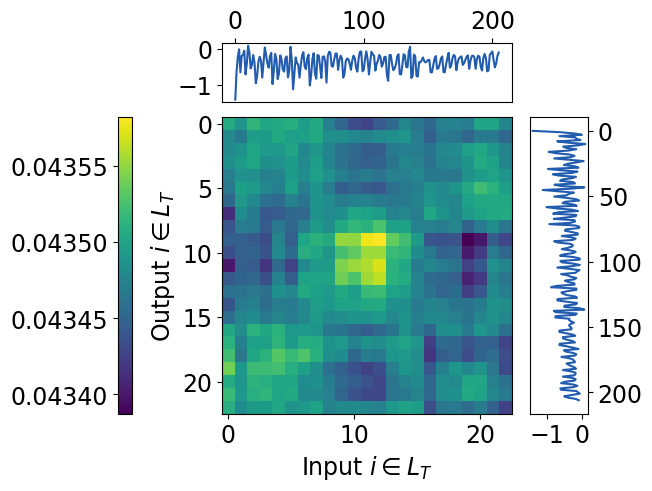

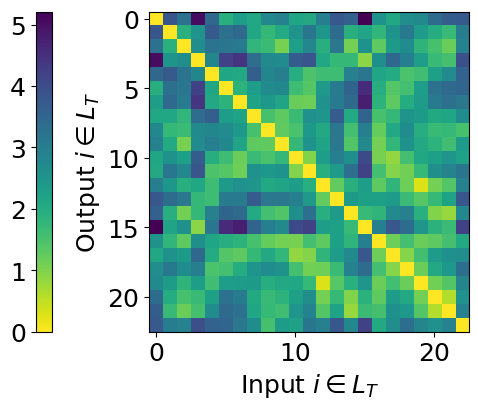

In [16]:
def my_fastdtw(sales1, sales2):
    return fastdtw(sales1,sales2)[0]

def print_attention_dwt(size,name,x,index=(1,0)):
    plt.rc('font', size=18) #controls default text size
   
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                        left=0.1, right=0.9, bottom=0.1, top=0.9,
                        wspace=0.05, hspace=0.05)
    ax = fig.add_subplot(gs[1, 0])
    # ax_x = fig.add_subplot(gs[0, 0])
    # ax_x.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    # ax_y = fig.add_subplot(gs[1, 1])
    # ax_y.tick_params(right=True, labelright=True, left=False, labelleft=False)

    lenT=np.ceil(len(x[index])/size)
    sale=[]
    for i in range(size):
        start=int(lenT*i)
        stop=int(lenT*(i+1))
        if i==size-1:
            stop=len(x[index])
        lin=np.arange(stop-start-1)
        sale.append(np.stack((lin,x[index[0]][0][start:stop-1]),axis=1))

    matrix=[]
    for i in sale:
        temp=[]
        for j in sale:
            temp.append(my_fastdtw(i,j))
        matrix.append(temp)
    matrix=np.array(matrix)
    im = ax.imshow(matrix,cmap="viridis_r")
    fig.colorbar(im,shrink=1,location="left") 

    ax.set_xlabel("Input $i\in L_T$")
    ax.set_ylabel("Output $i\in L_T$")
    plt.savefig("src/figures/{}.pdf".format(name))
    plt.show()
    return

for i in range(3):
    number=16
    plot_scalogram(X_test_freq[number][i])
    print_attention_fancy(model.get_attention_score(),"sumed_attention",X_test,(number,0))
    print_attention_dwt(23, "dtw",X_test,(number,i))


# Print multiple Attention score

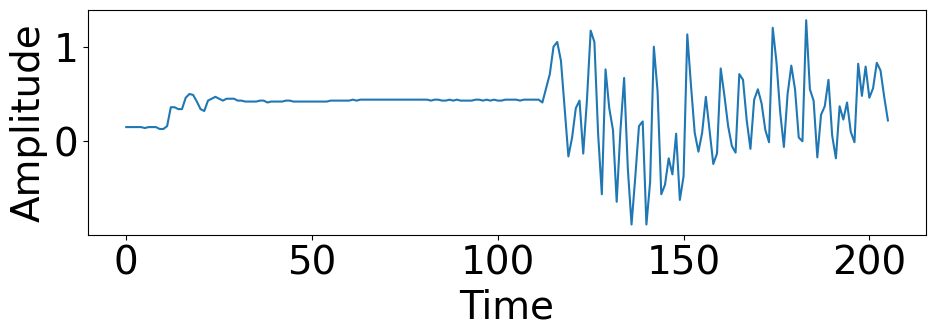

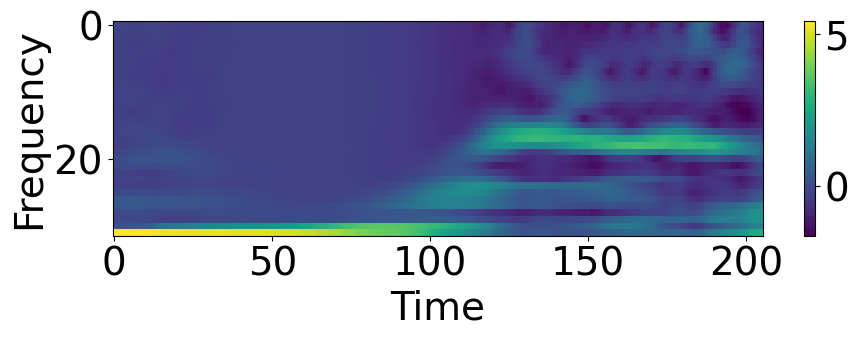

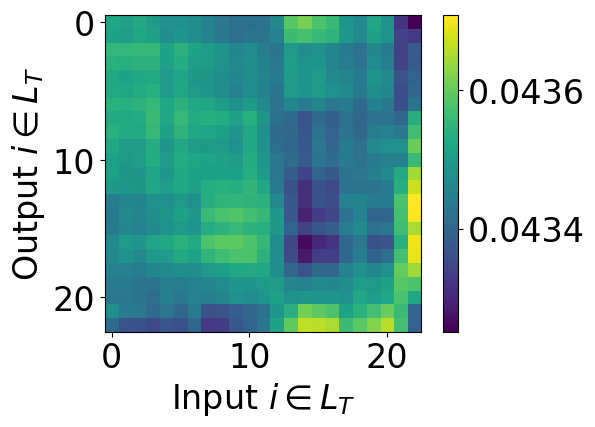

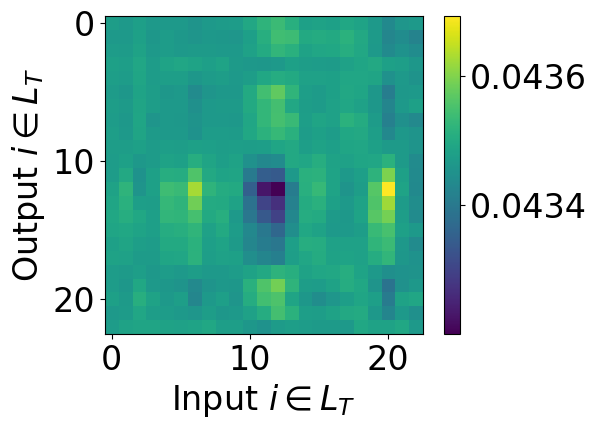

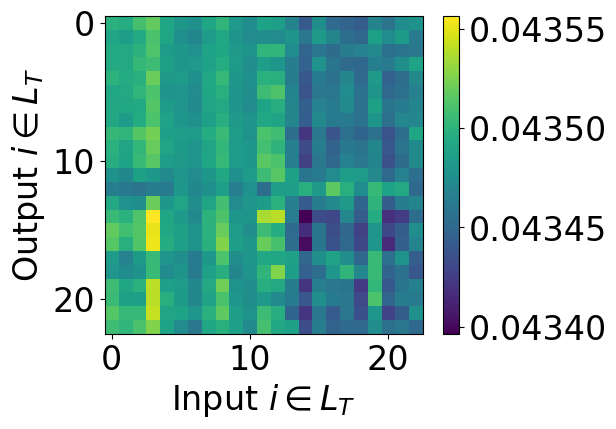

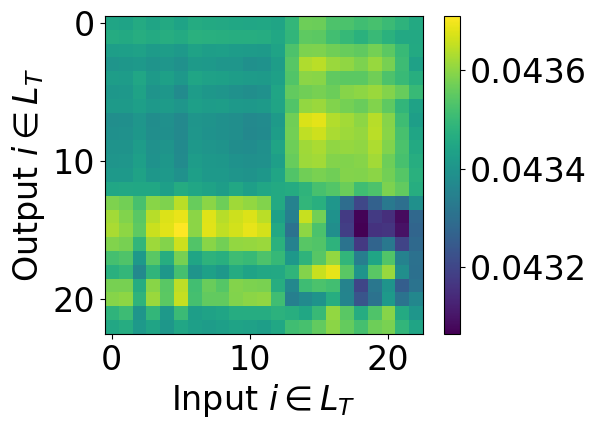

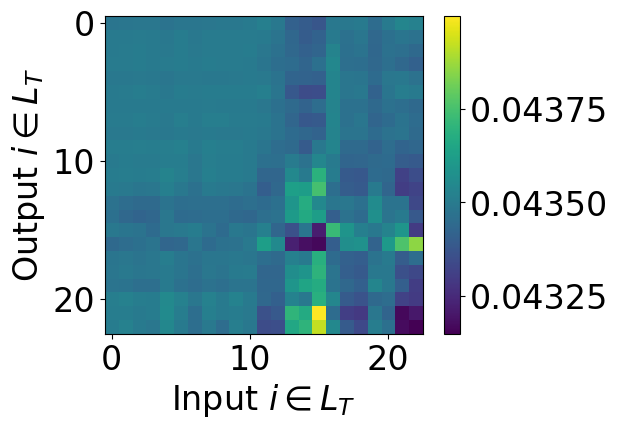

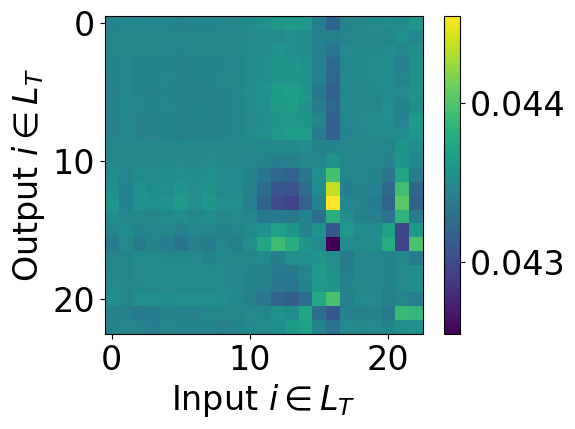

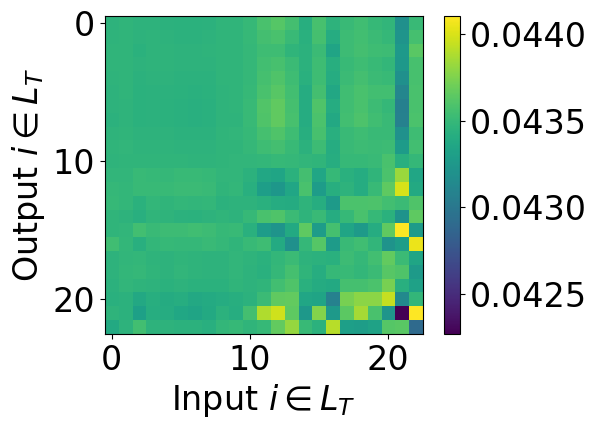

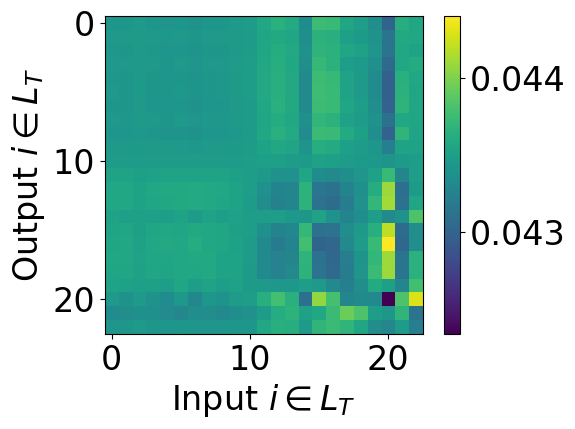

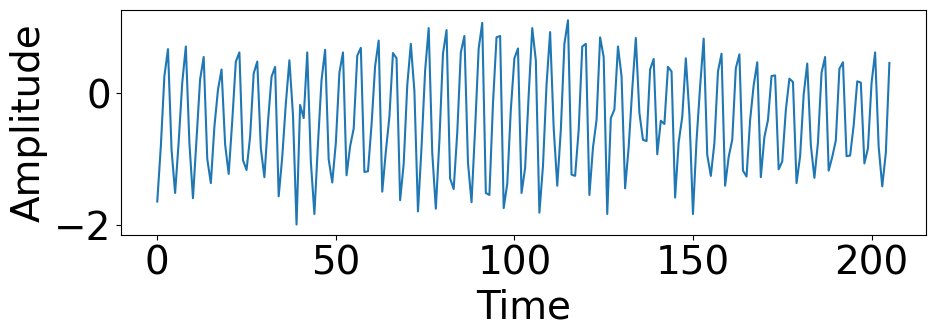

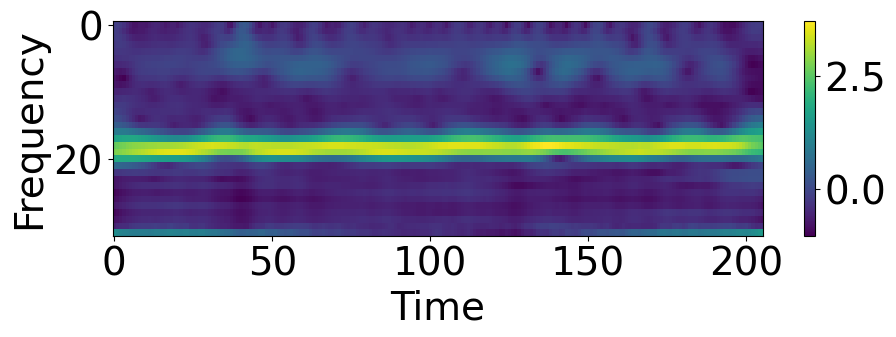

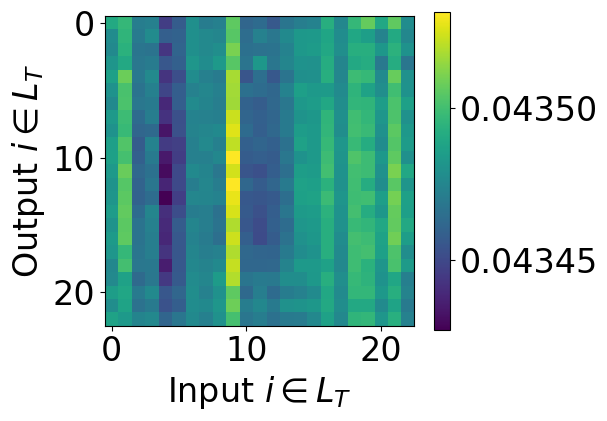

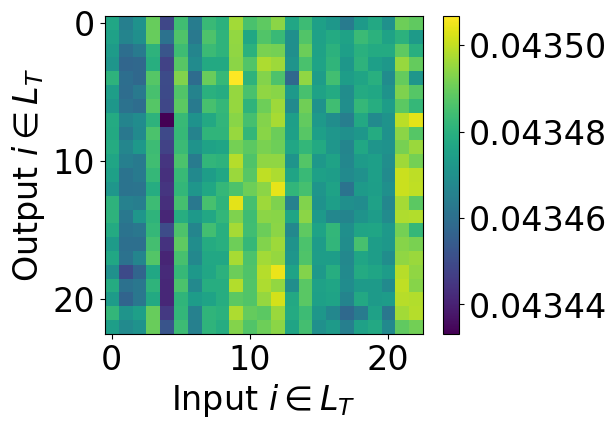

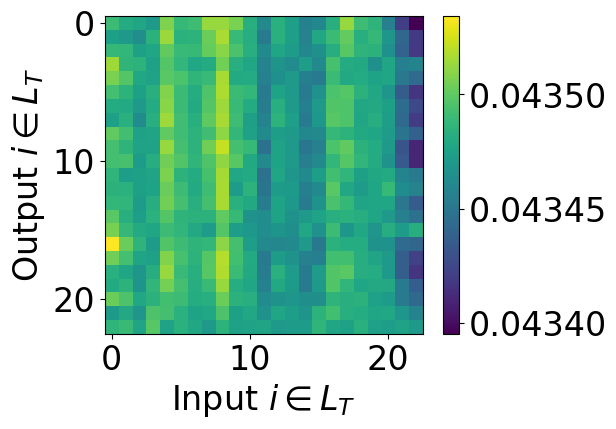

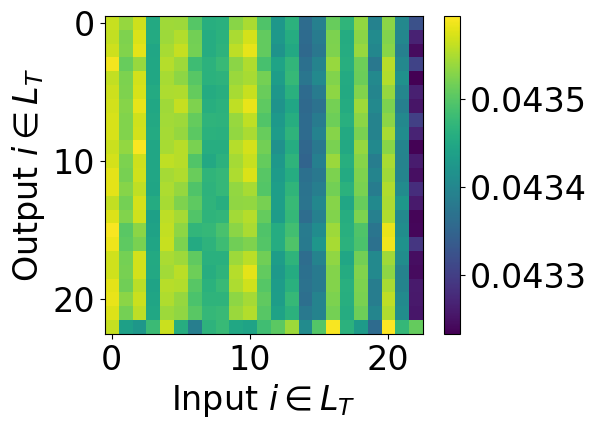

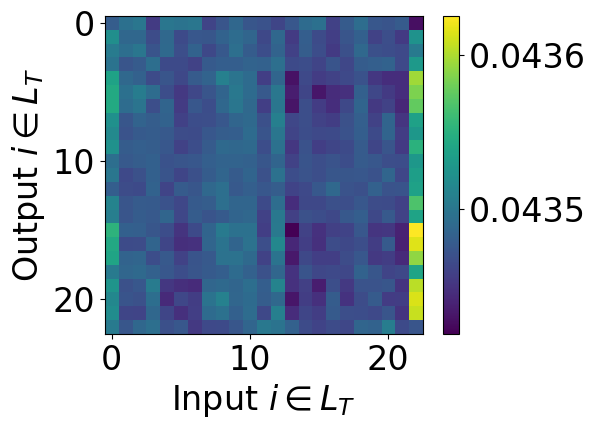

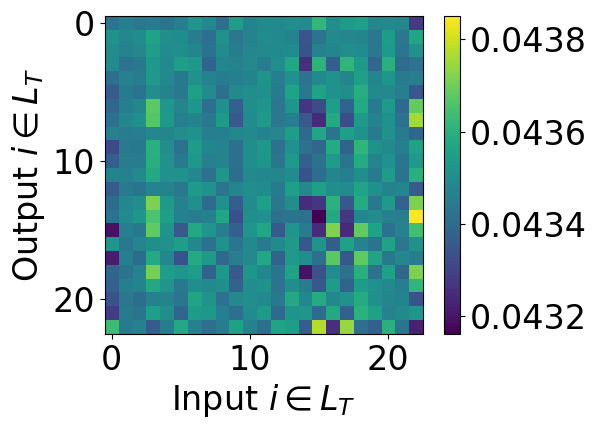

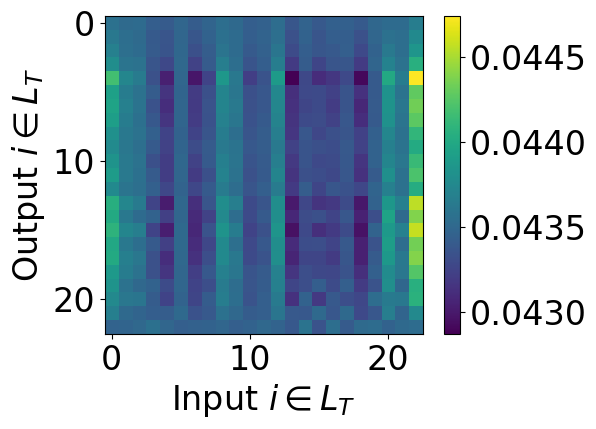

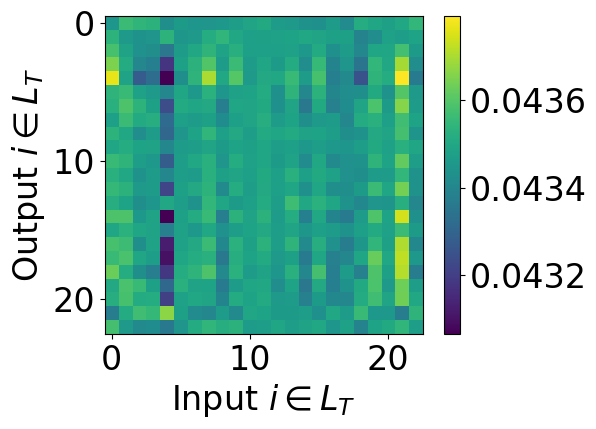

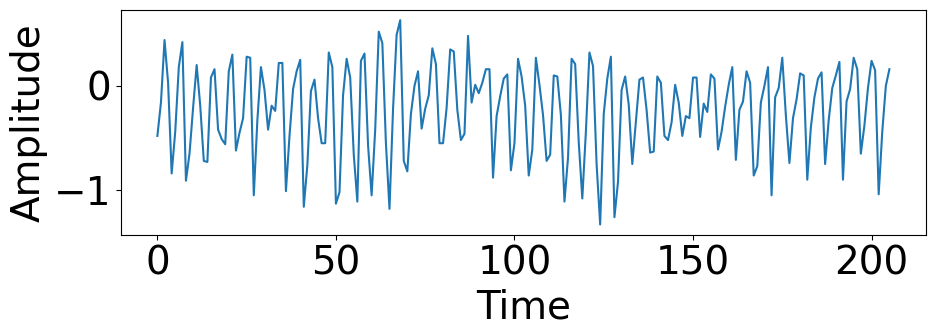

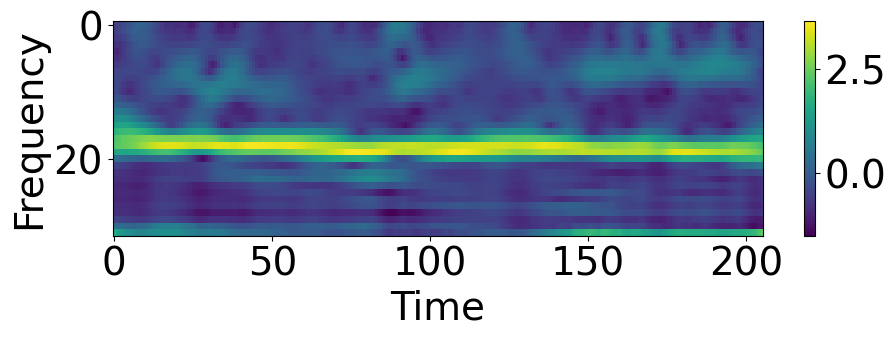

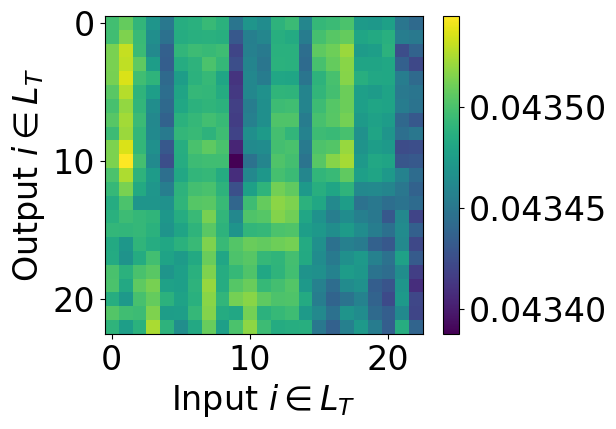

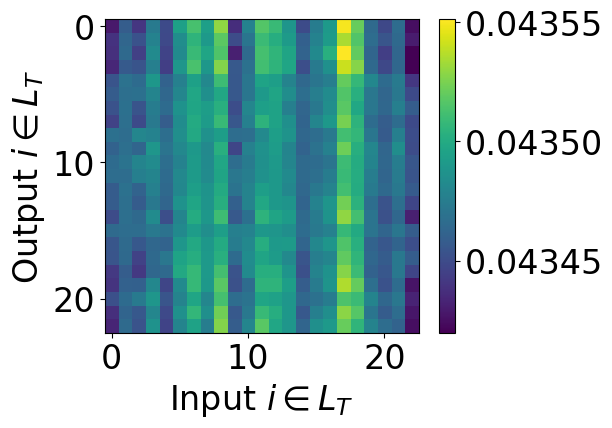

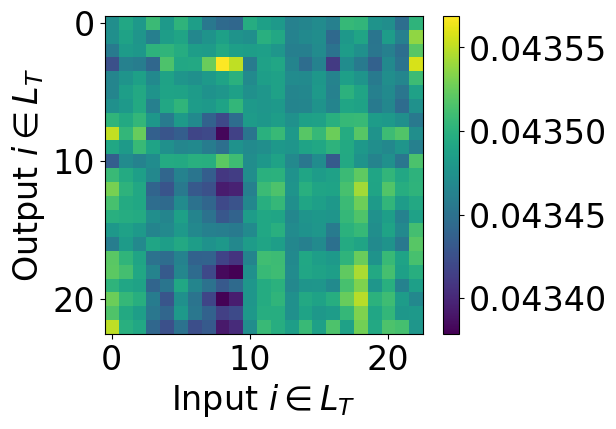

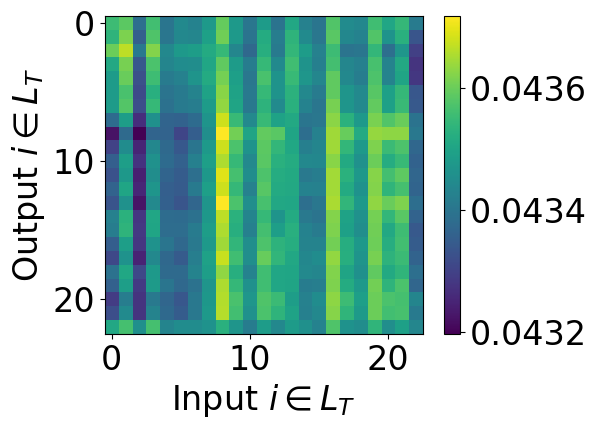

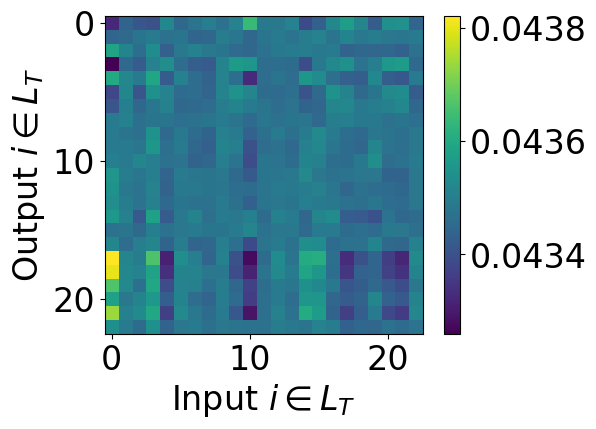

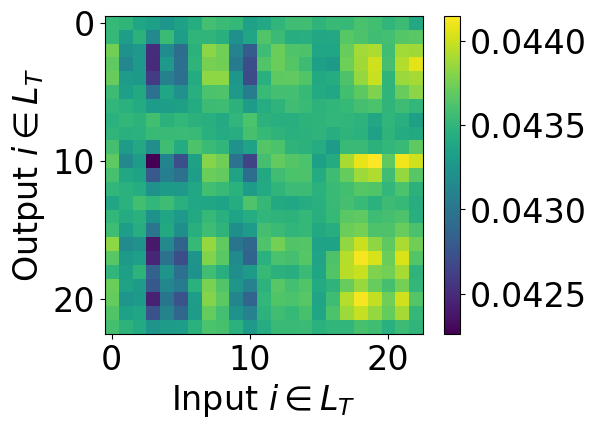

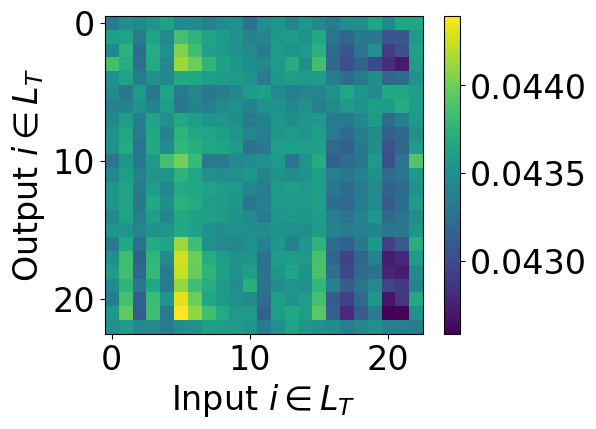

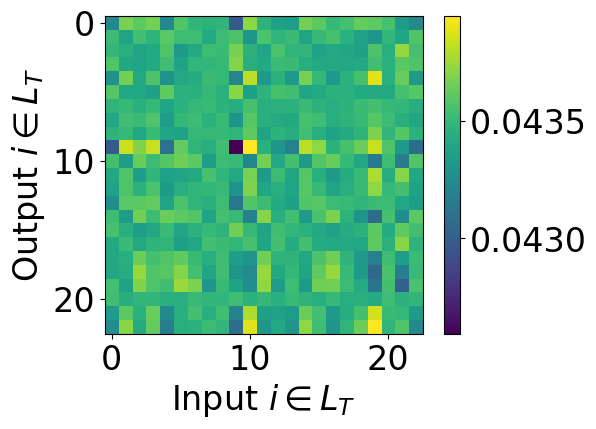

In [17]:
def full_attention(data,X,x_raw,index,p):
    plt.rc('font', size=28) #controls default text size
    plt.figure(figsize=(10,4))
    plt.plot(x_raw[index])
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.savefig("src/figures/app/appendix_raw{}.pdf".format(index[1]))
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(10,4))
    ax1 = fig.add_subplot()
    im=ax1.imshow(np.flip(np.transpose(X[index]),0), aspect="auto")
    fig.colorbar(im,ax=ax1) 
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig("src/figures/app/appendix_scal{}.pdf".format(index[1]))
    plt.show()

    plt.rc('font', size=24) #controls default text size
    mask=-1
    axis={0:"dimension",1:"time",2:"frequency"}[p]
    matrix=np.mean(data[0][p][index[0]],axis=2)[index[1]]
    for pet,ma in enumerate(matrix):
        if p==1:
            ma=ma[:mask,:mask]
        fig = plt.figure()
        ax1 = fig.add_subplot()
        im = ax1.imshow(ma)
        fig.colorbar(im,ax=ax1) 
        ax1.set_xlabel("Input $i\in L_T$")
        ax1.set_ylabel("Output $i\in L_T$")
        plt.tight_layout()
        plt.savefig("src/figures/app/appendix_{}_{}.pdf".format(index[1],pet))
        plt.show()
    return


for iz in range(3):
    y_pred = model(X_test_freq[:100],reconstructing=False, training=False)
    full_attention(model.get_attention_score(),X_test_freq,X_test,(30,iz),1)


$M=Q\cdot K^T$ Masked Multi Head Attention Mask (cross-time)


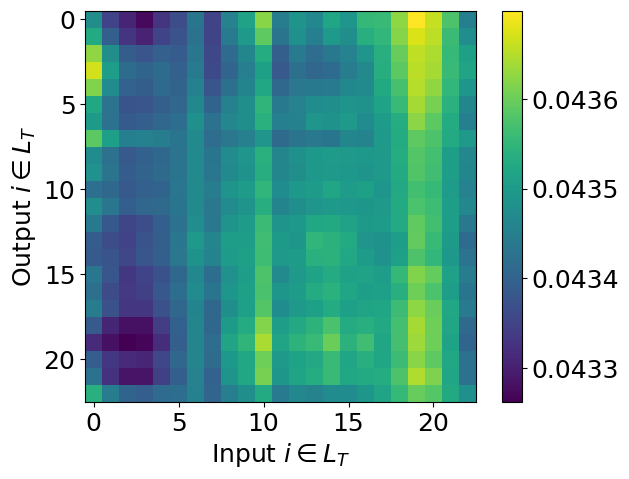

ValueError: Exception encountered when calling layer 'fully_connected_reconstruction' (type FullyConnectedReconstruction).

In this `tf.Variable` creation, the initial value's shape ((256, 816)) is not compatible with the explicitly supplied `shape` argument ((256, 256)).

Call arguments received by layer 'fully_connected_reconstruction' (type FullyConnectedReconstruction):
  • x=['tf.Tensor(shape=(2, 3, 24, 8, 20), dtype=float32)', 'tf.Tensor(shape=(2, 3, 12, 4, 20), dtype=float32)']
  • shape=ListWrapper(['3', '34', '8'])
  • training=False

In [18]:
def print_attention_scores(data,name,bars):
    plt.rc('font', size=18) #controls default text size
    mask=-1
    matrix=data[0][1][1][0][0][0][:mask,:mask]
    if(bars):
            fig = plt.figure(figsize=(8,5), constrained_layout=True)
            gs = fig.add_gridspec(1, 5)
            ax1 = fig.add_subplot(gs[0, 1:])
            im = ax1.imshow(matrix)
            fig.colorbar(im,ax=ax1) 
            matrix=np.where(matrix >0, 1, 0)
            hist=np.sum(matrix,axis=1)
            low = np.quantile(hist,0.1)
            colors = []
            for value in hist: # keys are the names of the boys
                if low > value:
                    colors.append(ETH_Rot)
                else:
                    colors.append(ETH_Blau)
            ax2 = fig.add_subplot(gs[0,0],sharey = ax1)
            ax2.barh(np.arange(23),hist, orientation='horizontal',color=colors,align='center')
            ax2.set_xlim([20,25])
            ax2.invert_xaxis()
    else:
        fig = plt.figure()
        ax1 = fig.add_subplot()
        im = ax1.imshow(matrix)
        fig.colorbar(im,ax=ax1) 
        plt.tight_layout()
    print("$M=Q\cdot K^T$ Masked Multi Head Attention Mask (cross-time)")
    ax1.set_xlabel("Input $i\in L_T$")
    ax1.set_ylabel("Output $i\in L_T$")
    plt.savefig("src/figures/{}.pdf".format(name))
    plt.show()
    return

y_pred = model(X_test_freq[:2],reconstructing=False, training=False)
print_attention_scores(model.get_attention_score(),"no_mask",False)
y_pred = model(X_test_freq[:2],reconstructing=True, training=False)
print_attention_scores(model.get_attention_score(),"ddm",True)

## Benchmark Results critical difference

In [106]:
df=pd.read_csv("scrapyard/dumpster/results_k10.csv", sep=',')
cf_df=pd.read_csv("results/02_benchmark.csv", sep=',').drop_duplicates(subset=['dataset',"acc"])
total_df=cf_df.merge(df, on='dataset', how='left').set_index('dataset')
total_df["Class-Former"]=total_df["T_acc"]
total_df["SD"]=total_df["T_std"]
classifiers=["Class-Former","SD","RISE","TSF","RSF","ResNet","1NN-DTW-I","cBOSS","DrCIF","ROCKET"]
total_df=total_df[classifiers].dropna(subset=["Class-Former"]).round(decimals = 3)
classifiers.remove('SD')
# total_df.to_csv("results/temp.csv")
print(total_df.to_latex(bold_rows=True,
                        index_names=False,
                        formatters={"SD": "$\pm$ {:.3f}".format},
                        float_format="{:.3f}".format,
                        caption="Accuracy of the ClassFormer on 18 \gls{uea} test datasets compared to the benchmark classifiers \cite{ruiz_great_2021}. The best accuracy score per dataset is marked bold. Additionally the standard deviation ($\pm$) for the ClassFormer is given for $n=3$.",
                        label="tab:benchmark",
                        column_format="|l|*{11}{>{\centering\\arraybackslash}p{1.3cm}|}",
                        position="htb"))

\begin{table}[htb]
\caption{Accuracy of the ClassFormer on 18 \gls{uea} test datasets compared to the benchmark classifiers \cite{ruiz_great_2021}. The best accuracy score per dataset is marked bold. Additionally the standard deviation ($\pm$) for the ClassFormer is given for $n=3$.}
\label{tab:benchmark}
\begin{tabular}{|l|*{12}{>{\centering\arraybackslash}p{1.3cm}|}}
\toprule
 & Class-Former & SD & RISE & TSF & RSF & ResNet & 1NN-DTW-I & cBOSS & DrCIF & ROCKET \\
\midrule
\textbf{ArticularyWordRecognition} & 0.937 & $\pm$ 0.005 & 0.947 & 0.950 & 0.987 & 0.980 & 0.927 & 0.983 & 0.980 & 0.997 \\
\textbf{AtrialFibrillation} & 0.333 & $\pm$ 0.000 & 0.267 & 0.267 & 0.067 & 0.333 & 0.333 & 0.133 & 0.200 & 0.200 \\
\textbf{BasicMotions} & 0.983 & $\pm$ 0.012 & 1.000 & 1.000 & 1.000 & 1.000 & 0.700 & 0.975 & 1.000 & 0.975 \\
\textbf{Cricket} & 0.903 & $\pm$ 0.011 & 0.986 & 0.917 & 0.986 & 1.000 & 0.958 & 0.944 & 0.986 & 1.000 \\
\textbf{Epilepsy} & 0.995 & $\pm$ 0.003 & 0.978 & 0.978 & 0.964

In [ ]:
print(classifiers)
total_df=total_df.dropna()
diagram = Diagram(
    total_df[classifiers].to_numpy(),
    treatment_names = total_df[classifiers].columns,
    maximize_outcome = True
)
diagram.average_ranks # the average rank of each treatment
diagram.get_groups(alpha=.05, adjustment="holm")
diagram.to_file(
    "results/critdd.tex",
    alpha = .05,
    adjustment = "holm",
    reverse_x = True,
    axis_options = {"title": "Accuracy"},
)

['Class-Former', 'RISE', 'TSF', 'RSF', 'ResNet', '1NN-DTW-I', 'STC', 'cBOSS', 'DrCIF', 'ROCKET']


/scratch_net/narigpu01/sbuehrer/conda_envs/tencu11/lib/python3.9/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


<function matplotlib.pyplot.show(close=None, block=None)>

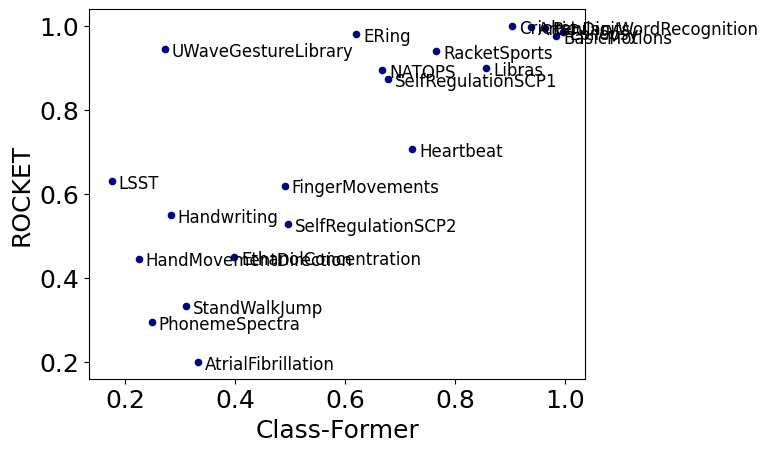

In [ ]:
total_df['index'] = total_df.index
ax1 = total_df.plot.scatter(x='Class-Former',  y='ROCKET', c='DarkBlue')
for idx, row in total_df.iterrows():
    ax1.annotate(row['index'], (row['Class-Former'], row['ROCKET']), xytext=(5,-5),
                textcoords='offset points', family='sans-serif', fontsize=12)
plt.show

## custom scheduler learning Rate

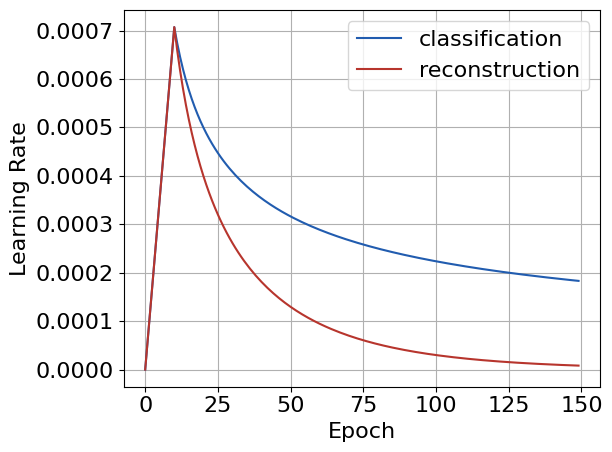

In [105]:
plt.rc('font', size=16) #controls default text size
d_model=20
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=5,steepness=1):
    super().__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps
    self.steepness=steepness

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)*((0.8**(step-self.warmup_steps))**self.steepness)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)*1e-02
recon_rate = CustomSchedule(d_model,10,0.1)
class_rate = CustomSchedule(d_model,10,0)


class_optimizer = tf.keras.optimizers.Adam(class_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
reco_optimizer = tf.keras.optimizers.Adam(recon_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
plt.plot(class_rate(tf.range(150, dtype=tf.float32)),label="classification",color=ETH_Blau)
plt.plot(recon_rate(tf.range(150, dtype=tf.float32)),label="reconstruction",color=ETH_Rot)
plt.legend()
plt.ylabel('Learning Rate')
plt.xlabel('Epoch')
plt.tight_layout()
plt.grid()
plt.savefig('src/figures/learning_rate.pdf')
plt.show()



## Ablation Study

In [102]:
benchmark_df=pd.read_csv("results/02_benchmark.csv", sep=',').drop_duplicates(subset=['dataset',"acc"])
benchmark_df["N-TSA + reconstruc + warmup"]=benchmark_df["T_acc"]
benchmark_df["SD1"]=benchmark_df["T_std"]
recon_df=pd.read_csv("results/05_ablation_study.csv", sep=',').drop_duplicates(subset=['dataset',"acc"])
recon_df["N-TSA + warmup"]=recon_df["T_acc"]
recon_df["SD2"]=recon_df["T_std"]

abl_df=recon_df.merge(benchmark_df, on='dataset', how='left')#

col=["dataset","N-TSA + reconstruc + warmup","SD1","N-TSA + warmup","SD2"]
abl_df=abl_df[col].set_index('dataset')

print(abl_df.to_latex(bold_rows=True,
                        index_names=False,
                        formatters={"SD1": "$\pm$ {:.3f}".format,"SD2": "$\pm$ {:.3f}".format},
                        float_format="{:.3f}".format,
                        caption="Accuracy of the ablation study ClassFormer on 18 \gls{uea} test datasets. The best accuracy score per dataset is marked bold. Additionally the standard deviation ($\pm$) is given for $n=3$.",
                        label="tab:ablation_study",
                        column_format="|l|*{4}{>{\centering\\arraybackslash}p{1.3cm}|}",
                        position="htb"))

\begin{table}[htb]
\caption{Accuracy of the ablation study ClassFormer on 18 \gls{uea} test datasets. The best accuracy score per dataset is marked bold. Additionally the standard deviation ($\pm$) is given for $n=3$.}
\label{tab:ablation_study}
\begin{tabular}{|l|*{4}{>{\centering\arraybackslash}p{1.3cm}|}}
\toprule
 & N-TSA + reconstruc + warmup & SD1 & N-TSA + warmup & SD2 \\
\midrule
\textbf{ArticularyWordRecognition} & 0.937 & $\pm$ 0.005 & 0.928 & $\pm$ 0.017 \\
\textbf{AtrialFibrillation} & 0.333 & $\pm$ 0.000 & 0.444 & $\pm$ 0.083 \\
\textbf{BasicMotions} & 0.983 & $\pm$ 0.012 & 0.983 & $\pm$ 0.024 \\
\textbf{Cricket} & 0.903 & $\pm$ 0.011 & 0.875 & $\pm$ 0.041 \\
\textbf{Epilepsy} & 0.995 & $\pm$ 0.003 & 0.995 & $\pm$ 0.003 \\
\textbf{ERing} & 0.620 & $\pm$ 0.274 & 0.217 & $\pm$ 0.033 \\
\textbf{PhonemeSpectra} & 0.249 & $\pm$ 0.003 & 0.248 & $\pm$ 0.006 \\
\textbf{EthanolConcentration} & 0.399 & $\pm$ 0.011 & 0.333 & $\pm$ 0.062 \\
\textbf{FingerMovements} & 0.490 & $\pm$ 0.0